### Libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import VarianceThreshold
import matplotlib.pyplot as plt

: 

### Reading in data

In [3]:
train = pd.read_csv("../Dataset/Train.csv")
test = pd.read_csv("../Dataset/Test.csv")

### Feature Extraction (Counts)

In [4]:
import importlib
import feature_extraction
importlib.reload(feature_extraction)
from feature_extraction import *

y_train, X_train, y_test, X_test = get_counts(train, test, 3, (1, 1))

### Baseline Logistic Regression Model

In [ ]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])
cm_display.plot()
plt.show()

tn, fp, fn, tp = cm.ravel()
accuracy = (tp + tn) / (tp + tn + fp + fn)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
mcc = (tp * tn - fp * fn) / ((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) ** 0.5

print({f'accuracy: {accuracy}'})
print({f'sensitivity: {sensitivity}'})
print({f'specificity: {specificity}'})
print({f'mcc: {mcc}'})

### Hyperparameter Turning with GridSearch

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, matthews_corrcoef

def mcc_scorer(y_test, y_pred):
    return matthews_corrcoef(y_test, y_pred)

param_grid = {
    'penalty': ['l1', 'l2'],  # Regularization penalty
    'C': [0.01, 0.1, 1, 10, 100],  # Inverse of regularization strength (smaller values specify stronger regularization)
    'solver': ['liblinear', 'saga'],  # Algorithm to use in the optimization problem
    'max_iter': [100, 200, 300]  # Maximum number of iterations
}

tuned_model = LogisticRegression()

mcc_scorer = make_scorer(mcc_scorer)

grid_search = GridSearchCV(estimator = tuned_model, param_grid = param_grid, cv = 3, scoring = mcc_scorer, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(best_params)

### Model After Hyperparameter Tuning

In [ ]:
best_model = grid_search.best_estimator_
tuned_y_pred = best_model.fit(X_test)

cm = confusion_matrix(y_test, tuned_y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])
cm_display.plot()
plt.show()

tn, fp, fn, tp = cm.ravel()
accuracy = (tp + tn) / (tp + tn + fp + fn)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
mcc = (tp * tn - fp * fn) / ((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) ** 0.5

print({f'accuracy: {accuracy}'})
print({f'sensitivity: {sensitivity}'})
print({f'specificity: {specificity}'})
print({f'mcc: {mcc}'})

### Using VarianceThreshold for feature selection

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The ma

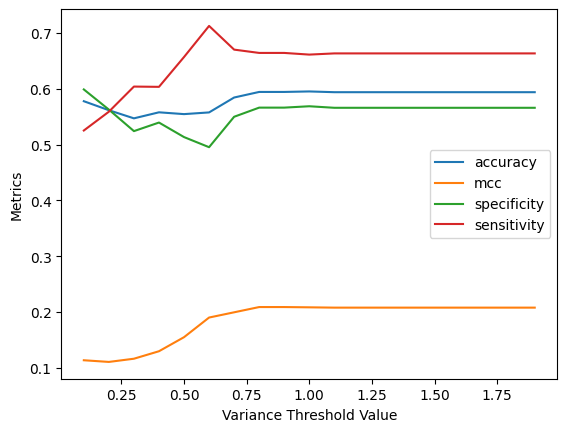

best threshold for variance for feature selection: 0.8
with corresponding metrics:
accuracy: 0.5945439582567281
sensitivity: 0.6644889485895714
specificity: 0.5664203471386836
mcc: 0.20782037514652693


In [5]:
mcc_arr = []
sensitivity_arr = []
specificity_arr = []
acccuracy_arr = []
variance_values = np.arange(0.1, 2, 0.1)

for val in variance_values:
    X_train, X_test = selecting_high_variance_features(X_train, X_test, val)

    model = LogisticRegression(C = 0.01, max_iter = 100, penalty = 'l2', solver = 'saga') # put in best parameters here
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    mcc = (tp * tn - fp * fn) / ((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) ** 0.5

    acccuracy_arr.append(accuracy)
    sensitivity_arr.append(sensitivity)
    specificity_arr.append(specificity)
    mcc_arr.append(mcc)

plt.plot(variance_values, acccuracy_arr, label = 'accuracy')
plt.plot(variance_values, mcc_arr, label = 'mcc')
plt.plot(variance_values, specificity_arr, label = 'specificity')
plt.plot(variance_values, sensitivity_arr, label = 'sensitivity')

plt.xlabel('Variance Threshold Value')
plt.ylabel('Metrics')
plt.legend()

plt.show()

best_var_threshold = variance_values[mcc_arr.index(max(mcc_arr))]
acc = acccuracy_arr[mcc_arr.index(max(mcc_arr))]
sens = sensitivity_arr[mcc_arr.index(max(mcc_arr))]
spec = specificity_arr[mcc_arr.index(max(mcc_arr))]
mcc_best = max(mcc_arr)
print(f'best threshold for variance for feature selection: {best_var_threshold}')
print('with corresponding metrics:')
print(f'accuracy: {acc}')
print(f'sensitivity: {sens}')
print(f'specificity: {spec}')
print(f'mcc: {mcc}')